In [302]:
import pandas as pd
import numpy as np
import xgboost as xgb


In [303]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import *

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from pandas import concat
import matplotlib.dates as md

from xgboost import XGBRegressor

In [304]:
weather_energy = pd.read_csv('Final.csv')
weather_energy.set_index('day',inplace=True)
weather_energy.shape

(827, 15)

In [305]:
weather_energy.head()

,avg_energy,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,WindGustKmph,cloudcover,humidity,precipMM,pressure,visibility,winddirDegree,IsBankHoliday
day,,,,,,,,,,,,,,,
2011-11-23,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,0.0,1027,7.0,257,0
2011-11-24,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,0.0,1028,10.0,205,0
2011-11-25,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024,9.0,240,0
2011-11-26,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026,10.0,229,1
2011-11-27,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021,10.0,258,1


In [306]:
weather_energy.columns.to_list()

['avg_energy',
 'maxtempC',
 'mintempC',
 'totalSnow_cm',
 'sunHour',
 'uvIndex',
 'moon_illumination',
 'WindGustKmph',
 'cloudcover',
 'humidity',
 'precipMM',
 'pressure',
 'visibility',
 'winddirDegree',
 'IsBankHoliday']

In [307]:
weather_energy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 827 entries, 2011-11-23 to 2014-02-26
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_energy         827 non-null    float64
 1   maxtempC           827 non-null    float64
 2   mintempC           827 non-null    float64
 3   totalSnow_cm       827 non-null    float64
 4   sunHour            827 non-null    float64
 5   uvIndex            827 non-null    float64
 6   moon_illumination  827 non-null    float64
 7   WindGustKmph       827 non-null    float64
 8   cloudcover         827 non-null    float64
 9   humidity           827 non-null    float64
 10  precipMM           827 non-null    float64
 11  pressure           827 non-null    int64  
 12  visibility         827 non-null    float64
 13  winddirDegree      827 non-null    int64  
 14  IsBankHoliday      827 non-null    int64  
dtypes: float64(12), int64(3)
memory usage: 103.4+ KB


In [308]:
#function to convert time series data to apply supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [309]:
def change_columnname(df):
    for cols in df.columns:
        print(cols[:4])

In [310]:
from sklearn.preprocessing import MinMaxScaler

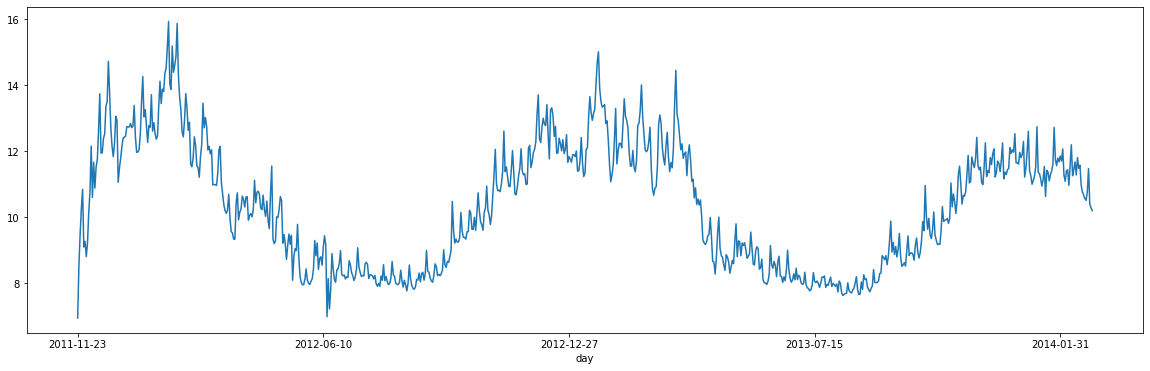

In [311]:
weather_energy["avg_energy"].plot(figsize=(20,6));


In [312]:
weather_energy.shape

(827, 15)

In [313]:
weather_energy.head()

,avg_energy,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,WindGustKmph,cloudcover,humidity,precipMM,pressure,visibility,winddirDegree,IsBankHoliday
day,,,,,,,,,,,,,,,
2011-11-23,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,0.0,1027,7.0,257,0
2011-11-24,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,0.0,1028,10.0,205,0
2011-11-25,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,0.2,1024,9.0,240,0
2011-11-26,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,0.0,1026,10.0,229,1
2011-11-27,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,0.3,1021,10.0,258,1


In [314]:
no_of_timesteps=6
no_of_timesteps_lead=2
reframed = series_to_supervised(weather_energy.values, no_of_timesteps,no_of_timesteps_lead)
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),...,var6(t+1),var7(t+1),var8(t+1),var9(t+1),var10(t+1),var11(t+1),var12(t+1),var13(t+1),var14(t+1),var15(t+1)
6,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,...,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0
7,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,...,2.0,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0
8,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,...,2.0,45.0,21.0,35.0,91.0,7.25,1012.0,9.0,254.0,0.0
9,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,...,2.0,52.0,36.0,60.0,91.0,7.25,1004.0,9.0,240.0,1.0
10,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,...,2.0,59.0,30.0,67.0,92.0,0.60,1001.0,10.0,246.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,11.490470,10.0,4.0,0.0,10.0,2.0,96.0,48.5,36.0,83.0,...,3.0,48.0,32.0,27.0,84.0,0.00,1009.0,10.0,223.0,1.0
822,11.582159,9.0,1.0,0.0,10.1,3.0,89.0,25.0,19.0,86.0,...,2.0,42.0,44.0,66.0,91.0,0.30,1011.0,9.0,186.0,1.0
823,10.979566,10.0,4.0,0.0,5.0,2.0,82.0,30.0,70.0,90.0,...,2.0,35.0,35.0,44.0,85.0,0.10,1006.0,10.0,175.0,0.0
824,10.781898,10.0,5.0,0.0,6.7,2.0,76.0,25.0,81.0,94.0,...,2.0,28.0,34.0,54.0,87.0,1.10,1001.0,9.0,186.0,0.0


In [315]:
change_columnname(reframed)

var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1
var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1
var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1
var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1
var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1
var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1
var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1
var1
var2
var3
var4
var5
var6
var7
var8
var9
var1
var1
var1
var1
var1
var1


In [316]:
reframed[454:][['var1(t-1)','var1(t)','var1(t+1)']]

,var1(t-1),var1(t),var1(t+1)
460,14.014282,13.059055,12.573332
461,13.059055,12.573332,12.058759
462,12.573332,12.058759,11.990561
463,12.058759,11.990561,12.048499
464,11.990561,12.048499,12.308851
...,...,...,...
821,10.573835,10.518126,10.776242
822,10.518126,10.776242,11.480411
823,10.776242,11.480411,10.411403
824,11.480411,10.411403,10.294997


In [317]:
reframed= reframed.reset_index(drop=True)
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),...,var6(t+1),var7(t+1),var8(t+1),var9(t+1),var10(t+1),var11(t+1),var12(t+1),var13(t+1),var14(t+1),var15(t+1)
0,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,...,2.0,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0
1,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,...,2.0,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0
2,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,...,2.0,45.0,21.0,35.0,91.0,7.25,1012.0,9.0,254.0,0.0
3,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,...,2.0,52.0,36.0,60.0,91.0,7.25,1004.0,9.0,240.0,1.0
4,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,...,2.0,59.0,30.0,67.0,92.0,0.60,1001.0,10.0,246.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,11.490470,10.0,4.0,0.0,10.0,2.0,96.0,48.5,36.0,83.0,...,3.0,48.0,32.0,27.0,84.0,0.00,1009.0,10.0,223.0,1.0
816,11.582159,9.0,1.0,0.0,10.1,3.0,89.0,25.0,19.0,86.0,...,2.0,42.0,44.0,66.0,91.0,0.30,1011.0,9.0,186.0,1.0
817,10.979566,10.0,4.0,0.0,5.0,2.0,82.0,30.0,70.0,90.0,...,2.0,35.0,35.0,44.0,85.0,0.10,1006.0,10.0,175.0,0.0
818,10.781898,10.0,5.0,0.0,6.7,2.0,76.0,25.0,81.0,94.0,...,2.0,28.0,34.0,54.0,87.0,1.10,1001.0,9.0,186.0,0.0


In [318]:
# drop columns we don't want to predict
we_le = len(weather_energy.columns)
col_array=np.arange(0,len(reframed.columns))
reframed=reframed.loc[:,(col_array<we_le*no_of_timesteps+we_le) | (col_array%(we_le)==0)]


In [319]:
reframed.shape

(820, 106)

In [320]:
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),...,var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var1(t+1)
0,6.952692,10.0,5.0,0.0,8.7,2.0,16.0,18.0,25.0,90.0,...,25.0,40.0,80.0,90.0,0.50,1010.0,9.0,205.0,0.0,8.813513
1,8.536480,13.0,8.0,0.0,8.7,3.0,9.0,30.0,45.0,92.0,...,32.0,32.0,33.0,85.0,0.00,1019.0,10.0,205.0,0.0,9.227707
2,9.499781,12.0,7.0,0.0,8.7,2.0,2.0,31.0,44.0,87.0,...,39.0,25.0,78.0,90.0,7.25,1007.0,9.0,143.0,0.0,10.145910
3,10.267707,12.0,6.0,0.0,8.2,3.0,5.0,35.0,30.0,90.0,...,45.0,21.0,35.0,91.0,7.25,1012.0,9.0,254.0,0.0,10.780273
4,10.850805,12.0,6.0,0.0,6.8,3.0,11.0,36.0,38.0,85.0,...,52.0,36.0,60.0,91.0,7.25,1004.0,9.0,240.0,1.0,12.163127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,11.490470,10.0,4.0,0.0,10.0,2.0,96.0,48.5,36.0,83.0,...,55.0,32.0,33.0,85.0,0.20,1003.0,9.0,228.0,0.0,10.776242
816,11.582159,9.0,1.0,0.0,10.1,3.0,89.0,25.0,19.0,86.0,...,48.0,32.0,27.0,84.0,0.00,1009.0,10.0,223.0,1.0,11.480411
817,10.979566,10.0,4.0,0.0,5.0,2.0,82.0,30.0,70.0,90.0,...,42.0,44.0,66.0,91.0,0.30,1011.0,9.0,186.0,1.0,10.411403
818,10.781898,10.0,5.0,0.0,6.7,2.0,76.0,25.0,81.0,94.0,...,35.0,35.0,44.0,85.0,0.10,1006.0,10.0,175.0,0.0,10.294997


In [321]:
# reframed.drop(['var1(t)','var1(t+1)','var1(t+2)','var1(t+3)','var1(t+4)','var1(t+5)'],axis=1,inplace=True)

In [322]:
n_train_time = 454; # hours used for training.....
original_n_train_time=n_train_time;
pred_list=[]; #predicted values that will replace the original test_y values
testing_rows=365;
#testing_rows=reframed.shape[0]-original_n_train_time-1
test1 = reframed.values[n_train_time:n_train_time+testing_rows, :] #original testing data, this will later be modified with the predicted data generated by for loop
test_y1 = test1[:, -1] #see comment in above line
batch_size_fit=1
train = reframed.values[:n_train_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test1[:, :-1], test1[:, -1]
# reshape input to be 3D [samples, timesteps, features]


In [323]:
reframed[['var1(t-1)','var1(t)','var1(t+1)']]

,var1(t-1),var1(t),var1(t+1)
0,9.103382,9.274873,8.813513
1,9.274873,8.813513,9.227707
2,8.813513,9.227707,10.145910
3,9.227707,10.145910,10.780273
4,10.145910,10.780273,12.163127
...,...,...,...
815,10.573835,10.518126,10.776242
816,10.518126,10.776242,11.480411
817,10.776242,11.480411,10.411403
818,11.480411,10.411403,10.294997


In [324]:
reframed[454:464][['var1(t-1)','var1(t)','var1(t+1)']]

,var1(t-1),var1(t),var1(t+1)
454,14.014282,13.059055,12.573332
455,13.059055,12.573332,12.058759
456,12.573332,12.058759,11.990561
457,12.058759,11.990561,12.048499
458,11.990561,12.048499,12.308851
459,12.048499,12.308851,12.735907
460,12.308851,12.735907,11.481859
461,12.735907,11.481859,10.860481
462,11.481859,10.860481,10.675248
463,10.860481,10.675248,10.889469


In [325]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# train_X = scaler.fit_transform(train_X)
# #train_X = train_X.reshape((train_X.shape[0], no_of_timesteps, we_le))

# print(train_X.shape)

In [326]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
model =  XGBRegressor()
# fit model
model.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [327]:
y_true = []
for j in range(0,testing_rows+1):
    print('Loop # ',j)
    print(reframed.values[n_train_time,(len(reframed.columns)-1-we_le)])
    test = reframed.values[n_train_time:n_train_time+1, :]
    test_X = test[:, :-1]
    test_y = test[:, -1]
    
    print("check test x--->")
    print(reframed[n_train_time:n_train_time+1])
    print("check test ends x --->")
#     test_X = scaler.transform(test_X)
    #test_X = test_X.reshape((test_X.shape[0], no_of_timesteps, we_le))
    yhat = model.predict(test_X)
    if n_train_time+1<len(reframed):
        for k in range(0,len(reframed.columns),we_le):
            if((k+we_le)<(len(reframed.columns)-1)):
                reframed.values[n_train_time+1,k]=reframed.values[n_train_time,(k+we_le)];
        print('starts here')
        print(n_train_time+1,(len(reframed.columns)-1-we_le))
        print(reframed.values[n_train_time+1,(len(reframed.columns)-1-we_le)])
        print('ends here')
        reframed.values[n_train_time+1,(len(reframed.columns)-1-we_le)]=yhat;
        print('starts here')
        print(n_train_time+1,(len(reframed.columns)-1-we_le))
        print(reframed.values[n_train_time+1,(len(reframed.columns)-1-we_le)])
        print('ends here')
    #     reframed.values[n_train_time+1,0]=yhat;
    n_train_time=n_train_time+1
    pred_list=np.append(pred_list,yhat)
    y_true=np.append(y_true,test_y)
    print(reframed[n_train_time-1:n_train_time])
    print(yhat)
n_train_time=original_n_train_time

Loop #  0
13.05905549357143
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
454  11.385007       10.0        0.0        0.0       10.2        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
454       59.0        9.0       20.0        81.0  ...    100.0     29.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
454     86.0      86.0       0.4    1026.0       8.0     182.0       0.0   

     var1(t+1)  
454  12.573332  

[1 rows x 106 columns]
check test ends x --->
starts here
455 90
12.573332295915002
ends here
starts here
455 90
13.038673400878906
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
454  11.385007       10.0        0.0        0.0       10.2        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
454       59.0        9.0       20.0        81.0  ...    100.0     29.0   

     var9(t)  var10(t)  var11

starts here
493 90
11.73147926680859
ends here
starts here
493 90
13.73691463470459
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
492  13.102777        6.0       -3.0        0.0        9.0        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
492       83.0       20.0       35.0        75.0  ...     43.0     33.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
492     76.0      78.0       2.9    1014.0       5.0      28.0       0.0   

     var1(t+1)  
492  11.731479  

[1 rows x 106 columns]
[13.736915]
Loop #  39
13.73691463470459
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
493  13.380431        6.0       -3.0        0.3        7.7        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
493       77.0       21.0       58.0        80.0  ...     36.0     33.0   

     var9(t)  var10(t)  var11(t)  var12(t

starts here
522 90
8.868705563111856
ends here
starts here
522 90
9.527364730834961
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
521  10.500469       10.0        1.0        0.0       10.3        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
521       87.0       19.0       57.0        80.0  ...     46.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
521     11.0      70.0       0.0    1020.0      10.0     245.0       0.0   

     var1(t+1)  
521   8.868706  

[1 rows x 106 columns]
[9.527365]
Loop #  68
9.527364730834961
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
522  11.144499       12.0       -1.0        0.0       13.5        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
522       80.0       18.0       38.0        73.0  ...     40.0     26.0   

     var9(t)  var10(t)  var11(t)  var12(t)

[1 rows x 106 columns]
check test ends x --->
starts here
551 90
8.737453204296656
ends here
starts here
551 90
9.722529411315918
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
550  10.235621       19.0        5.0        0.0       16.5        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
550       91.0       18.0       33.0        67.0  ...     50.0     18.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
550     35.0      74.0       0.2    1023.0      10.0     294.0       1.0   

     var1(t+1)  
550   8.737453  

[1 rows x 106 columns]
[9.722529]
Loop #  97
9.722529411315918
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
551   9.563268       16.0        7.0        0.0       16.5        4.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
551       84.0       21.0        7.0        70.0  ...     43.0     17.0 

[1 rows x 106 columns]
[8.439067]
Loop #  126
8.439066886901855
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
580   8.273465       19.0        8.0        0.0       16.8        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
580       87.0       13.0       25.0        70.0  ...     47.0     16.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
580     65.0      75.0       0.1    1017.0       8.0     265.0       0.0   

     var1(t+1)  
580   8.248034  

[1 rows x 106 columns]
check test ends x --->
starts here
581 90
8.248033919715143
ends here
starts here
581 90
8.468924522399902
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
580   8.273465       19.0        8.0        0.0       16.8        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
580       87.0       13.0       25.0        70.0  ...     47.0     16.0

starts here
610 90
7.959776351171137
ends here
starts here
610 90
8.128890991210938
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
609   8.215982       26.0       15.0        0.0       15.9        6.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
609       91.0       15.0       19.0        70.0  ...     50.0     21.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
609     74.0      92.0       5.1    1014.0       9.0     215.0       0.0   

     var1(t+1)  
609   7.959776  

[1 rows x 106 columns]
[8.128891]
Loop #  156
8.128890991210938
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
610   7.903265       25.0       15.0        0.0       13.5        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
610       84.0       17.0       30.0        73.0  ...     44.0     20.0   

     var9(t)  var10(t)  var11(t)  var12(t

starts here
639 90
7.747788270753998
ends here
starts here
639 90
8.196529388427734
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
638    8.12774       24.0       16.0        0.0       12.3        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
638       95.0        9.0       62.0        82.0  ...     54.0      8.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
638      8.0      70.0       0.0    1022.0      10.0     125.0       0.0   

     var1(t+1)  
638   7.747788  

[1 rows x 106 columns]
[8.196529]
Loop #  185
8.196529388427734
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
639   8.138134       26.0       15.0        0.0       13.4        5.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
639       88.0       16.0       61.0        75.0  ...     47.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t

[1 rows x 106 columns]
check test ends x --->
starts here
667 90
8.628415899827585
ends here
starts here
667 90
8.227690696716309
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
666    8.57276       17.0        7.0        0.0        7.6        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
666       95.0       23.0       65.0        87.0  ...     64.0      6.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
666     55.0      84.0       0.0    1012.0       7.0     110.0       0.0   

     var1(t+1)  
666   8.628416  

[1 rows x 106 columns]
[8.227691]
Loop #  213
8.227690696716309
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
667   8.573385       22.0        8.0        0.0       11.6        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
667       98.0       14.0       34.0        83.0  ...     58.0     16.0

starts here
693 90
9.311661470284834
ends here
starts here
693 90
7.965506553649902
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
692   8.691985       13.0        7.0        0.0       10.8        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
692       71.0       16.0       59.0        89.0  ...     88.0     31.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
692     59.0      93.0       0.7    1006.0       8.0     184.0       0.0   

     var1(t+1)  
692   9.311661  

[1 rows x 106 columns]
[7.9655066]
Loop #  239
7.965506553649902
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
693    8.69948       14.0        6.0        0.0        6.9        3.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
693       78.0       25.0       62.0        96.0  ...     81.0     32.0   

     var9(t)  var10(t)  var11(t)  var12(

starts here
725 90
11.770955990519582
ends here
starts here
725 90
10.155169486999512
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
724   9.395679        9.0        3.0        0.0        8.7        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
724       88.0       11.0       22.0        87.0  ...     72.0     32.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
724     39.0      88.0       0.1    1017.0      10.0     310.0       0.0   

     var1(t+1)  
724  11.770956  

[1 rows x 106 columns]
[10.1551695]
Loop #  271
10.155169486999512
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
725   10.39784        9.0        4.0        0.0        3.3        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
725       95.0       11.0       80.0        95.0  ...     65.0     25.0   

     var9(t)  var10(t)  var11(t)  va

[1 rows x 106 columns]
[9.16185]
Loop #  308
9.161849975585938
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
762  10.148068       10.0        5.0        0.0        5.8        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
762       55.0       43.0       56.0        88.0  ...     14.0     48.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
762     68.0      91.0       6.5    1011.0       7.0     193.0       0.0   

     var1(t+1)  
762  11.913917  

[1 rows x 106 columns]
check test ends x --->
starts here
763 90
11.91391723983134
ends here
starts here
763 90
8.718902587890625
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
762  10.148068       10.0        5.0        0.0        5.8        2.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
762       55.0       43.0       56.0        88.0  ...     14.0     48.0 

starts here
793 90
11.68516887183488
ends here
starts here
793 90
9.395353317260742
ends here
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
792   8.842431        7.0        2.0        0.0        6.9        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
792       52.0       30.0       53.0        92.0  ...     11.0     25.0   

     var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  \
792     99.0      98.0      7.25     993.0       7.0      88.0       0.0   

     var1(t+1)  
792  11.685169  

[1 rows x 106 columns]
[9.395353]
Loop #  339
9.395353317260742
check test x--->
     var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
793   8.553463        7.0        1.0        0.0        3.3        1.0   

     var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)  ...  var7(t)  var8(t)  \
793       45.0       21.0       83.0        94.0  ...      4.0     13.0   

     var9(t)  var10(t)  var11(t)  var12(t

In [328]:
len(pred_list)

366

In [329]:
list1 = reframed['var1(t+1)'][:454]

In [330]:
len(list1)

454

In [331]:
list1

0       8.813513
1       9.227707
2      10.145910
3      10.780273
4      12.163127
         ...    
449    12.791991
450    12.856232
451    13.245570
452    14.014282
453    13.059055
Name: var1(t+1), Length: 454, dtype: float64

In [332]:
len(reframed)

820

In [333]:
list1 = list1.to_list()
pred_list = list(pred_list)
list2 = list1 + pred_list

In [334]:
reframed[454:464][['var1(t-1)','var1(t)','var1(t+1)']]

,var1(t-1),var1(t),var1(t+1)
454,14.014282,13.059055,12.573332
455,13.059055,13.038673,12.058759
456,13.038673,13.218931,11.990561
457,13.218931,13.071529,12.048499
458,13.071529,12.525764,12.308851
459,12.525764,12.715337,12.735907
460,12.715337,13.580873,11.481859
461,13.580873,13.127227,10.860481
462,13.127227,12.505406,10.675248
463,12.505406,12.406227,10.889469


In [335]:
reframed.loc[454]

var1(t-6)      11.385007
var2(t-6)      10.000000
var3(t-6)       0.000000
var4(t-6)       0.000000
var5(t-6)      10.200000
                ...     
var12(t)     1026.000000
var13(t)        8.000000
var14(t)      182.000000
var15(t)        0.000000
var1(t+1)      12.573332
Name: 454, Length: 106, dtype: float64

In [336]:
reframed['predictedlist'] = list2


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [337]:
reframed[454:][['var1(t-1)','var1(t)','var1(t+1)','predictedlist']]

,var1(t-1),var1(t),var1(t+1),predictedlist
454,14.014282,13.059055,12.573332,13.038673
455,13.059055,13.038673,12.058759,13.218931
456,13.038673,13.218931,11.990561,13.071529
457,13.218931,13.071529,12.048499,12.525764
458,13.071529,12.525764,12.308851,12.715337
...,...,...,...,...
815,11.530951,11.480960,10.776242,11.654626
816,11.480960,11.654626,11.480411,12.237783
817,11.654626,12.237783,10.411403,11.859668
818,12.237783,11.859668,10.294997,11.552821


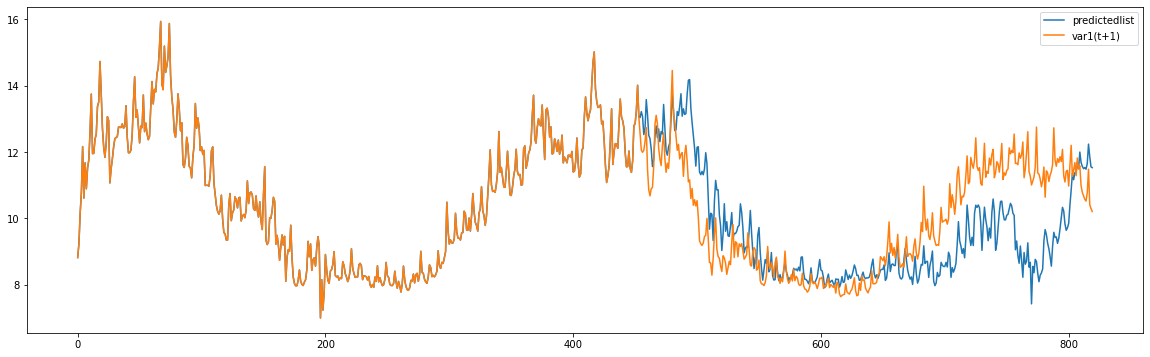

In [338]:
reframed[["predictedlist","var1(t+1)"]].plot(figsize=(20,6));

Text(0.5, 0, 'Time')

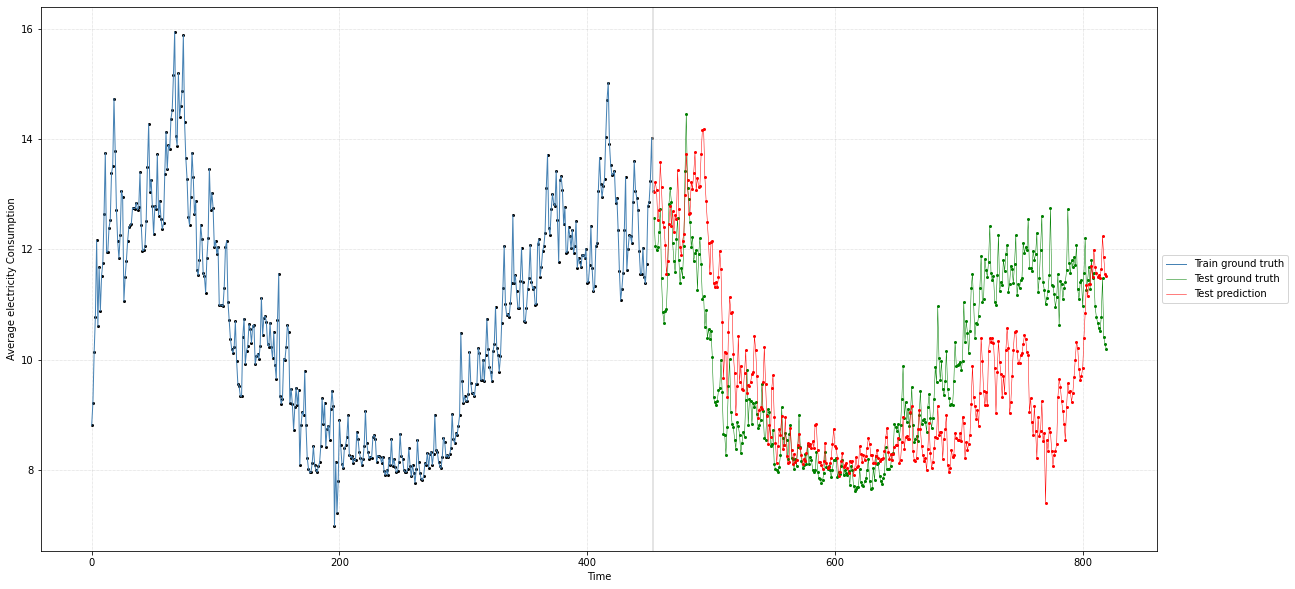

In [339]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(20, 10), sharex=True)

train = reframed[:454]
axes.plot(train.index, train['var1(t+1)'], 'ko', markersize=2, )
axes.plot(train.index, train['var1(t+1)'], color='steelblue', lw=1,label='Train ground truth')

test = reframed[454:]
axes.plot(test.index, test['var1(t+1)'], 'go', markersize=2, )
axes.plot(test.index, test['var1(t+1)'], 'g', lw=0.5, label='Test ground truth')
axes.plot(test.index, test.predictedlist, color='red', lw=0.5, label='Test prediction')
axes.plot(test.index, test.predictedlist, 'ro', markersize=2, )

axes.axvline(train.index[-1], color='0.8', alpha=0.7)
axes.set_ylabel(f'Average electricity Consumption')
axes.grid(ls=':', lw=0.5)
axes.legend(loc='center left', bbox_to_anchor=(1,0.5))
axes.set_xlabel('Time')

In [340]:
import numpy as np
from sklearn.metrics import mean_absolute_error


print(mean_absolute_error(y_true, pred_list))

1.0719059612642114


In [ ]:
import shap

In [342]:
X_test = reframed[454:].drop(['var1(t+1)','predictedlist'],axis=1)

In [343]:
def plot_abs_SHAP_summary(df_x, df_shap, max_display=None, shap_name = 'shap_plot', clean_name_dict={}, save=False):
    
    """ SHAP Summary Plot """
    
    import shap
    
    # Get correlations and importances
    corrs = df_x.corrwith(df_shap)
    shap_importances = df_shap.abs().mean()
    shap_importances.sort_values(ascending=False, inplace=True)
    corrs = corrs.loc[shap_importances.index]
    
    # Configure plot inputs
    if not max_display:
        max_display = len(shap_importances)
    shap_importances = shap_importances.iloc[:max_display]
    corrs = corrs.iloc[:max_display]
    norm = plt.Normalize(corrs.min(), corrs.max())
    colors = plt.cm.coolwarm(norm(corrs)) 
    scalar_color_map = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm) #if you don't like my colors, change here
    scalar_color_map.set_array([])
    labels = shap_importances.index.tolist()
    if len(clean_name_dict) > 0:
        labels = [ clean_name_dict.get(item,item) for item in labels ]
        
    
    # Plot
    plt.figure(figsize=(12,len(shap_importances)*0.5))
    sns.barplot(x=shap_importances, y=np.arange(len(shap_importances)), orient='h', palette=colors, edgecolor="black")
    sns.despine(top=True, right=True)
    colorbar = plt.colorbar(scalar_color_map, aspect=50)
    colorbar.set_label('SHAP-feature correlation', fontsize=14)
    colorbar.set_ticks(np.arange(-1,1.25,0.25))
    plt.yticks(np.arange(len(shap_importances)), labels=labels, fontsize=12)
    plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontsize=14)
    plt.title('SHAP feature importance', fontsize=18)
    # Save plot #
    if save:
        timestmp = datetime.now().strftime("%d%m%Y_%H%M%S")
        plt.savefig('outputs/{}_{}.jpg'.format(shap_name,timestmp), dpi = 200, bbox_inches='tight')
    plt.show()

In [344]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
df_shap_oos = pd.DataFrame(data=shap_values, columns=X_test.columns, 
                       index=X_test.index)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [345]:
import yaml
read_write = 'read'
if read_write == 'read':
    with open('clean_feature_names.yaml', 'r') as file:
        clean_names = yaml.load(file, Loader=yaml.FullLoader)

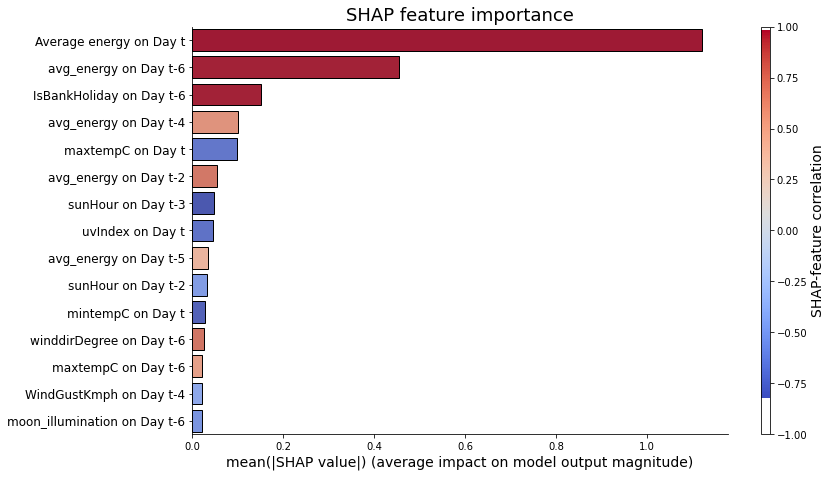

In [346]:
import seaborn as sns
plot_abs_SHAP_summary(X_test, df_shap_oos, max_display=15, 
                      shap_name = 'all',clean_name_dict=clean_names,save=False)

In [347]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
df_shap_oos = pd.DataFrame(data=shap_values, columns=X_test.columns, 
                       index=X_test.index)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [348]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_SHAP_corrs(df_x, df_shap, format_dict=None, max_display=None):
    
    # Get correlations and importances
    corrs = df_x.corrwith(df_shap)
    shap_importances = df_shap.abs().mean()
    shap_importances.sort_values(ascending=False, inplace=True)
    corrs = corrs.loc[shap_importances.index]
    
    # Configure plot inputs
    if not max_display:
        max_display = len(shap_importances)
    corrs = corrs.iloc[:max_display]
    labels = corrs.index
    
    if format_dict:
        old_labels = labels
        labels = []
        for label in old_labels:
            labels.append(format_dict[label])
    
    # Plot
    plt.figure(figsize=(12,len(shap_importances)*0.5))
    sns.barplot(x=corrs, y=np.arange(len(corrs)), orient='h', color='crimson', edgecolor="black")
    sns.despine(top=True, right=True)
    plt.yticks(np.arange(len(corrs)), labels=labels, fontsize=12)
    plt.xlabel('Directional correlation', fontsize=14)
    plt.title('Feature correlations', fontsize=18)
    plt.savefig('Directional_correlation.jpg',dpi = 200, bbox_inches='tight')
    plt.show()

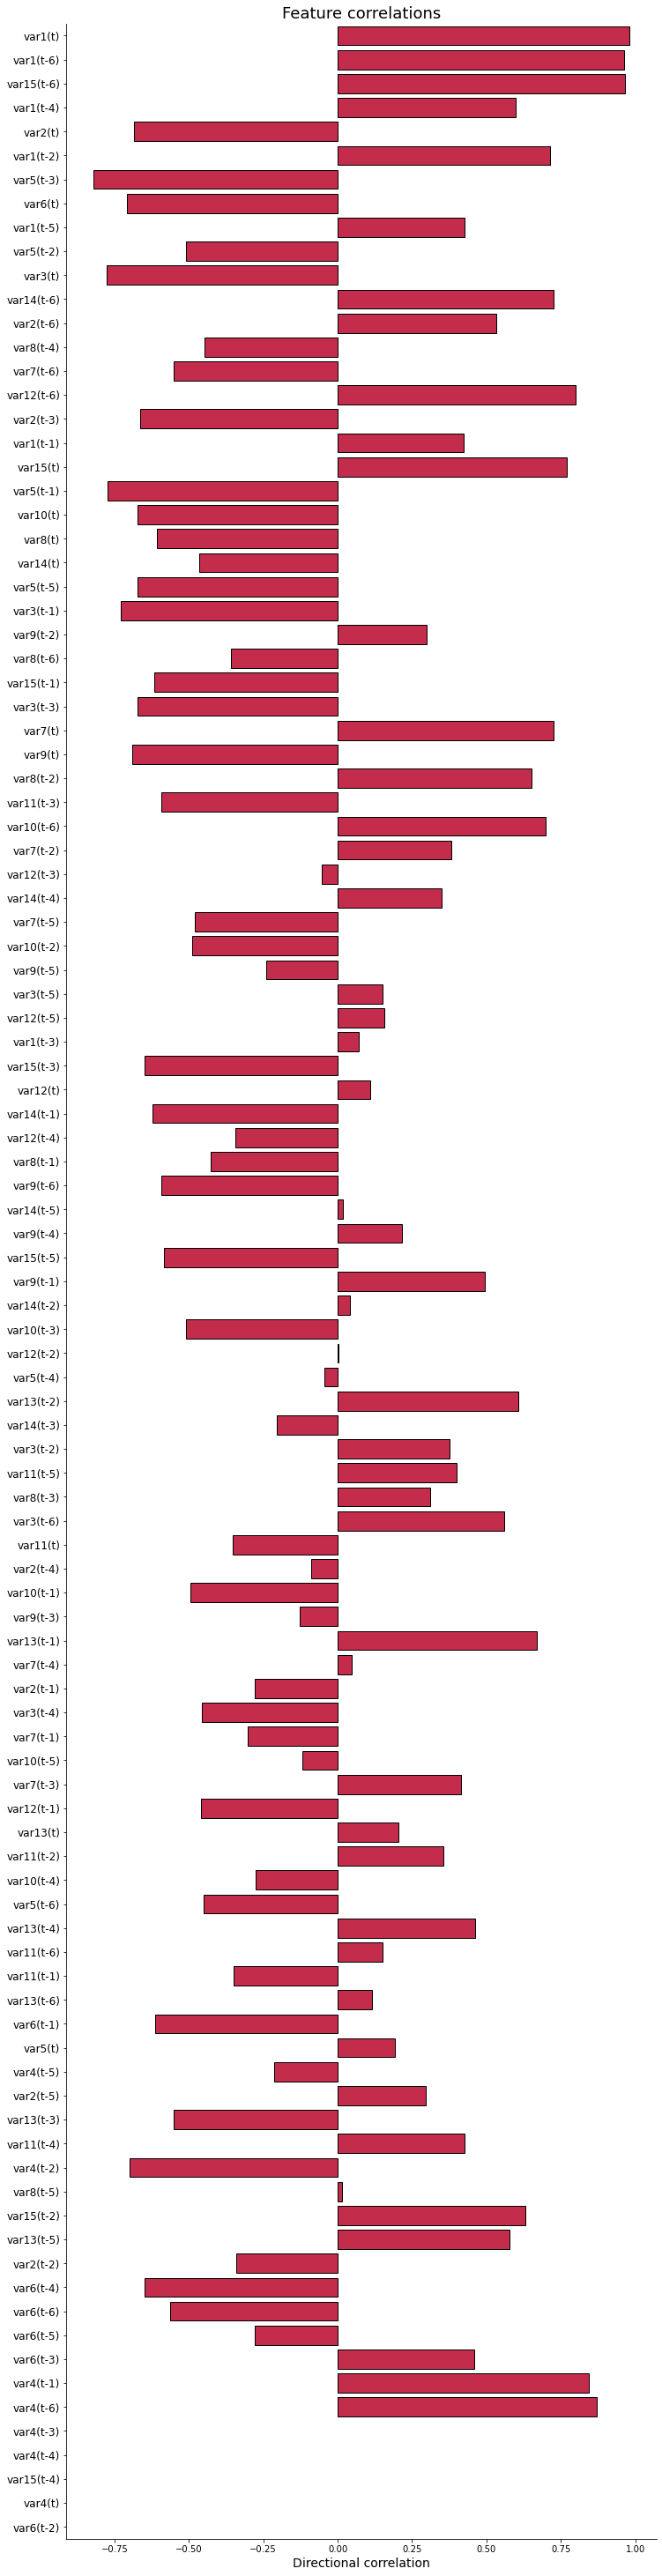

In [349]:
plot_SHAP_corrs(X_test,df_shap_oos)

In [48]:
#import the libraries for error calculation
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

#Calculate error of the model with RMSE, MSE, MAE, MAPE
print("RMSE: ",mean_squared_error(y_true, pred_list))
print("MSE: ",mean_squared_error(y_true, pred_list, squared=False))
print("MAE: ",mean_absolute_error(y_true, pred_list))
print("MAPE: ",mean_absolute_percentage_error(y_true, pred_list))

RMSE:  1.4481734373899093
MSE:  1.2034007800354416
MAE:  0.9421456552212871
MAPE:  0.09476608894696083
